<a href="https://colab.research.google.com/github/mpbeck/ANS-128-GP-The-Explorers-/blob/main/code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
# Change runtime to R
system("git clone https://github.com/mpbeck/ANS-128-GP-The-Explorers-.git")

In [4]:
library(tidyverse)
library(dplyr)
library(lubridate)
library(cluster)
#install.packages("caret")
library(caret)
#install.packages("rpart")
library(rpart)
#install.packages("rpart.plot")
library(rpart.plot)
#install.packages("forcats")
library(forcats)
#install.packages("pROC")
library(pROC)
data <- read.csv("/content/ANS-128-GP-The-Explorers-/Avian Influenza (HPAI).csv")
#class(data)
#head(data)

In [5]:
# Data cleaning
#summary(data$target_H5_HPAI)
data <- data %>%
  mutate(
    Common_Name = str_replace_all(Common_Name, " ", "_"),
    Locality = str_replace_all(Locality, " ", "_"),
    Species = as.factor(Common_Name),
    State = as.factor(State),
    County = as.factor(County),
    Locality = as.factor(Locality),
    target_H5_HPAI = as.factor(target_H5_HPAI),
    Year = as.integer(as.character(Year)),
    Month = as.integer(as.character(Month)),
    Day = as.integer(as.character(Day)),
    date = make_date(Year, Month, Day),
    day_of_year = yday(date) # Converted date to number of days in the given year
  )

#head(data[, c("Species", "State", "County", "Locality", "day_of_year", "target_H5_HPAI")])
#summary(data[, c("Species", "State", "County", "Locality", "Year", "target_H5_HPAI")])
head(data)
#data$Parent_Species == data$Scientific_Name

,X_id,Scientific_Name,Common_Name,Date,Year,Month,Day,Time,Country,Country_State_County,State,County,Locality,Latitude,Longitude,Parent_Species,target_H5_HPAI,Species,date,day_of_year
,<int>,<chr>,<chr>,<chr>,<int>,<int>,<int>,<int>,<chr>,<chr>,<fct>,<fct>,<fct>,<dbl>,<dbl>,<chr>,<fct>,<fct>,<date>,<dbl>
1,1,Acrocephalus scirpaceus,Eurasian_Reed_Warbler,2015-09-15T00:00:00,2015,9,15,1100,Ireland,IE-C-GY,Connaught,Galway,Inishmore_(Inis_M�r),53.1291,-9.7507,Acrocephalus scirpaceus,0,Eurasian_Reed_Warbler,2015-09-15,258
2,2,Acrocephalus scirpaceus,Eurasian_Reed_Warbler,2015-09-15T00:00:00,2015,9,15,1100,Ireland,IE-C-GY,Connaught,Galway,Inishmore_(Inis_M�r),53.1291,-9.7507,Acrocephalus scirpaceus,0,Eurasian_Reed_Warbler,2015-09-15,258
3,3,Limosa haemastica,Hudsonian_Godwit,2015-09-15T00:00:00,2015,9,15,1100,Ireland,IE-C-GY,Connaught,Galway,Inishmore_(Inis_M�r),53.1291,-9.7507,Limosa haemastica,0,Hudsonian_Godwit,2015-09-15,258
4,4,Limosa haemastica,Hudsonian_Godwit,2015-09-15T00:00:00,2015,9,15,1100,Ireland,IE-C-GY,Connaught,Galway,Inishmore_(Inis_M�r),53.1291,-9.7507,Limosa haemastica,0,Hudsonian_Godwit,2015-09-15,258
5,5,Limosa haemastica,Hudsonian_Godwit,2015-09-15T00:00:00,2015,9,15,1100,Ireland,IE-C-GY,Connaught,Galway,Inishmore_(Inis_M�r),53.1291,-9.7507,Limosa haemastica,0,Hudsonian_Godwit,2015-09-15,258
6,6,Muscicapa striata,Spotted_Flycatcher,2015-09-15T00:00:00,2015,9,15,1100,Ireland,IE-C-GY,Connaught,Galway,Inishmore_(Inis_M�r),53.1291,-9.7507,Muscicapa striata,0,Spotted_Flycatcher,2015-09-15,258


In [7]:
num_species <- data %>%
  distinct(Common_Name) %>%
  nrow()
length(unique(data$Common_Name)) == num_species # 410 species
length(unique(data$State)) # 4 States
length(unique(data$County)) # 27 Counties
length(unique(data$Locality)) # 1288 Localities
length(unique(data$Year)) # 21 Years

model <- glm(target_H5_HPAI ~ 1 + Year + day_of_year + County, data = data, family = binomial)
summary(model)

[1] TRUE

[1] 4

[1] 27

[1] 1288

[1] 21


Call:
glm(formula = target_H5_HPAI ~ 1 + Year + day_of_year + County, 
    family = binomial, data = data)

Coefficients:
                  Estimate Std. Error z value Pr(>|z|)    
(Intercept)     -94.848923 245.264436  -0.387    0.699    
Year              0.039593   0.010054   3.938 8.21e-05 ***
day_of_year       0.002007   0.000241   8.327  < 2e-16 ***
CountyCavan      13.643175 244.426135   0.056    0.955    
CountyClare      12.214893 244.425181   0.050    0.960    
CountyCork       12.579469 244.425169   0.051    0.959    
CountyDonegal    11.864990 244.425219   0.049    0.961    
CountyDublin     13.372037 244.425157   0.055    0.956    
CountyGalway     12.940613 244.425161   0.053    0.958    
CountyKerry      12.485134 244.425169   0.051    0.959    
CountyKildare    11.705973 244.425871   0.048    0.962    
CountyKilkenny   12.518147 244.425384   0.051    0.959    
CountyLaoighis    0.082645 670.344382   0.000    1.000    
CountyLaois       0.171323 371.035366   0.000    1.

Confusion Matrix and Statistics

          Reference
Prediction     0     1
         0 13619  2556
         1     0     0
                                          
               Accuracy : 0.842           
                 95% CI : (0.8363, 0.8476)
    No Information Rate : 0.842           
    P-Value [Acc > NIR] : 0.5053          
                                          
                  Kappa : 0               
                                          
 Mcnemar's Test P-Value : <2e-16          
                                          
            Sensitivity : 1.000           
            Specificity : 0.000           
         Pos Pred Value : 0.842           
         Neg Pred Value :   NaN           
             Prevalence : 0.842           
         Detection Rate : 0.842           
   Detection Prevalence : 1.000           
      Balanced Accuracy : 0.500           
                                          
       'Positive' Class : 0               
                  

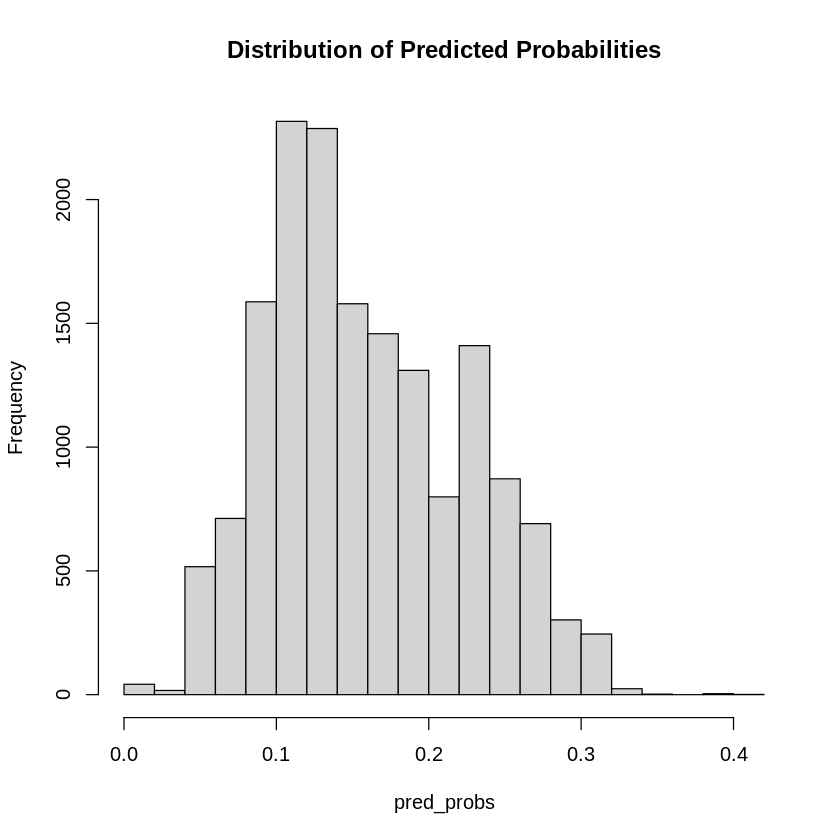

In [11]:
# Generate predicted probabilities
pred_probs <- predict(model, type = "response", na.action = na.exclude)
valid_indices <- which(!is.na(pred_probs))
actual_labels <- data$target_H5_HPAI[valid_indices]
pred_labels <- ifelse(pred_probs[valid_indices] > 0.5, 1, 0)

# Ensure factor levels match
pred_labels <- factor(pred_labels, levels = c(0,1))
actual_labels <- factor(actual_labels, levels = c(0,1))

conf_matrix <- confusionMatrix(pred_labels, actual_labels)

print(conf_matrix)

hist(pred_probs, breaks = 20, main = "Distribution of Predicted Probabilities")

In [114]:
# Decision tree
#data <- subset(data, select = -c(Common_Name, Date, Scientific_Name, Country, State, County, Month, Day, Time, X_id))
#head(data)
data$target_H5_HPAI <- as.factor(data$target_H5_HPAI)
independent_vars <- setdiff(names(data), "target_H5_HPAI")
categorical_vars <- c("Country_State_County", "Locality", "Parent_Species", "Species")

# Convert categorical variables to factors
for (var in categorical_vars) {
  if (var %in% independent_vars) {
    data[[var]] <- factor(data[[var]])  # Convert only if in independent variables
  }
}

# Split into training (70%) and testing (30%) sets
set.seed(123)
train_index <- createDataPartition(data$target_H5_HPAI, p = 0.7, list = FALSE)
train_data <- data[train_index, ]
test_data <- data[-train_index, ]

tree_model <- rpart(target_H5_HPAI ~ ., data = train_data[, c(independent_vars, "target_H5_HPAI")],
                    method = "class", control = rpart.control(cp = 0.002, maxdepth = 4))
#printcp(tree_model)
#rpart.plot(tree_model, type = 2, extra = 104, box.palette = "auto",
           #tweak = 1.5, cex = 0.8, faclen = 0, varlen = 0,
           #main = "Decision Tree for Avian Influenza Prediction")

# Feature importance plot
importance <- tree_model$variable.importance
#barplot(importance, horiz = TRUE, las = 1, col = "steelblue", main = "Feature Importance (Decision Tree)", xlab = "Importance Score", ylab = "Features", xlim = c(0,3000))
#print(importance)

# Make predictions on test data
preds <- predict(tree_model, test_data[, independent_vars], type = "class")
conf_matrix <- confusionMatrix(preds, test_data$target_H5_HPAI)
print(conf_matrix)

Confusion Matrix and Statistics

          Reference
Prediction    0    1
         0 4085    8
         1   30  767
                                          
               Accuracy : 0.9922          
                 95% CI : (0.9893, 0.9945)
    No Information Rate : 0.8415          
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.9712          
                                          
 Mcnemar's Test P-Value : 0.0006577       
                                          
            Sensitivity : 0.9927          
            Specificity : 0.9897          
         Pos Pred Value : 0.9980          
         Neg Pred Value : 0.9624          
             Prevalence : 0.8415          
         Detection Rate : 0.8354          
   Detection Prevalence : 0.8370          
      Balanced Accuracy : 0.9912          
                                          
       'Positive' Class : 0               
                        

[1] 0


        0         1 
0.8429833 0.1570167 


        0         1 
0.8399166 0.1600834 

[1] 16.304

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "AUC: 0.997540495124133"


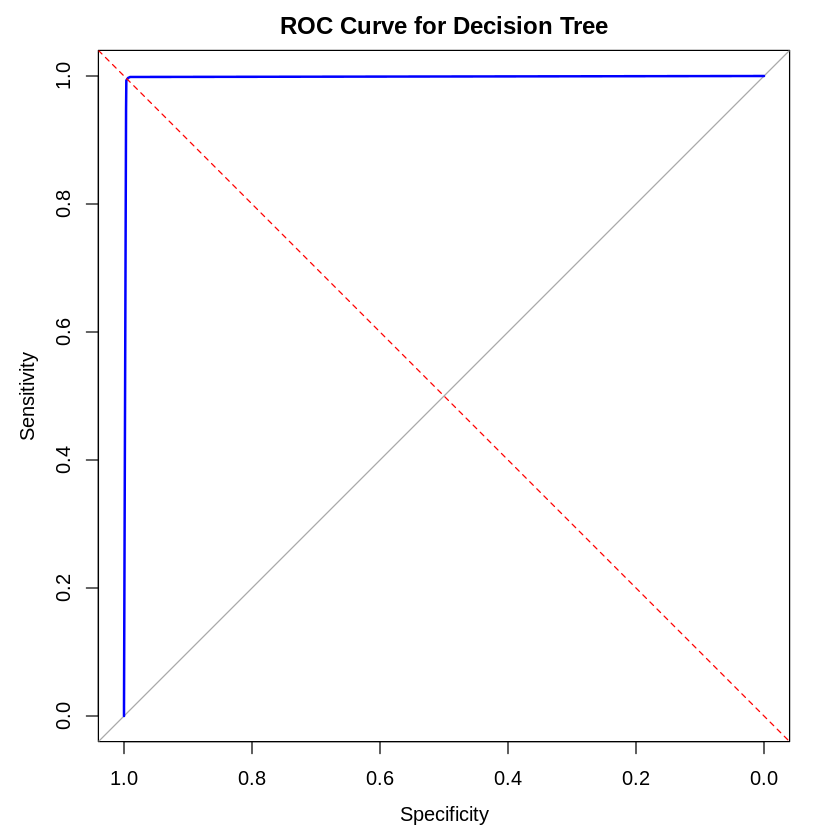

In [117]:
# Generate random row indices for the training set (70% of total data)
train_index <- sample(seq_len(nrow(data)), size = 0.5 * nrow(data))

# Subset the data based on the randomly selected indices
train_data <- data[train_index, ]
test_data <- data[-train_index, ]  # Remaining 30% as test set

# Verify that the test set has never been seen before
sum(train_index %in% setdiff(1:nrow(data), train_index))  # Should return 0

# Check the new class distributions in training and test sets
table(train_data$target_H5_HPAI) / nrow(train_data)
table(test_data$target_H5_HPAI) / nrow(test_data)

0.001*nrow(data)



# Get predicted probabilities (class = 1)
pred_probs <- predict(tree_model, test_data, type = "prob")[,2]

# Compute ROC Curve and AUC
roc_obj <- roc(test_data$target_H5_HPAI, pred_probs)
auc_value <- auc(roc_obj)

# Print AUC Score
print(paste("AUC:", auc_value))

# Plot ROC Curve
plot(roc_obj, col = "blue", lwd = 2, main = "ROC Curve for Decision Tree")
abline(a=0, b=1, lty=2, col="red")  # Add diagonal reference line

Warning message:
“cex and tweak both specified, applying both”


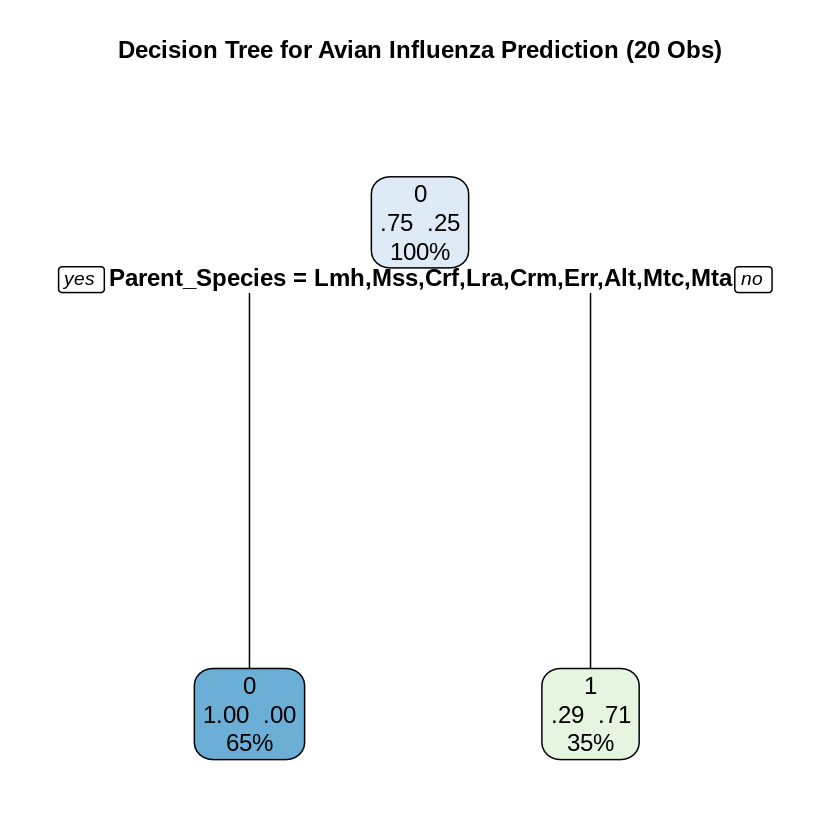

In [90]:
small_data <- data[1:20, ]

small_data$target_H5_HPAI <- as.factor(small_data$target_H5_HPAI)

independent_vars <- setdiff(names(small_data), "target_H5_HPAI")

# Ensure categorical variables are treated as factors but DROP UNUSED LEVELS
categorical_vars <- c("Country_State_County", "Locality", "Parent_Species", "Species")

for (var in categorical_vars) {
    if (var %in% independent_vars) {
        small_data[[var]] <- factor(small_data[[var]], levels = unique(small_data[[var]]))
    }
}

tree_model_small <- rpart(
    formula = target_H5_HPAI ~ .,
    data = small_data,
    method = "class",
    control = rpart.control(cp = 0.00002, maxdepth = 4)
)

rpart.plot(
    tree_model_small,
    type = 2,
    extra = 104,
    box.palette = "auto",
    tweak = 1.5,
    cex = 0.8,
    faclen = 3,  # Only show first 3 letters of factor names
    varlen = 0,  # Ensures readable labels
    main = "Decision Tree for Avian Influenza Prediction (20 Obs)"
)

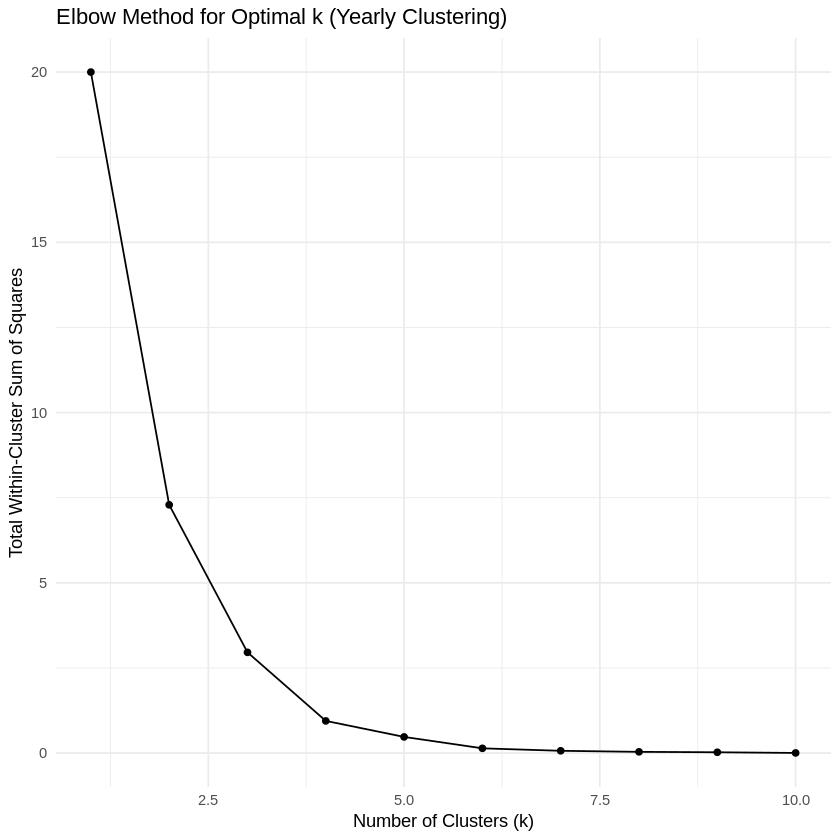

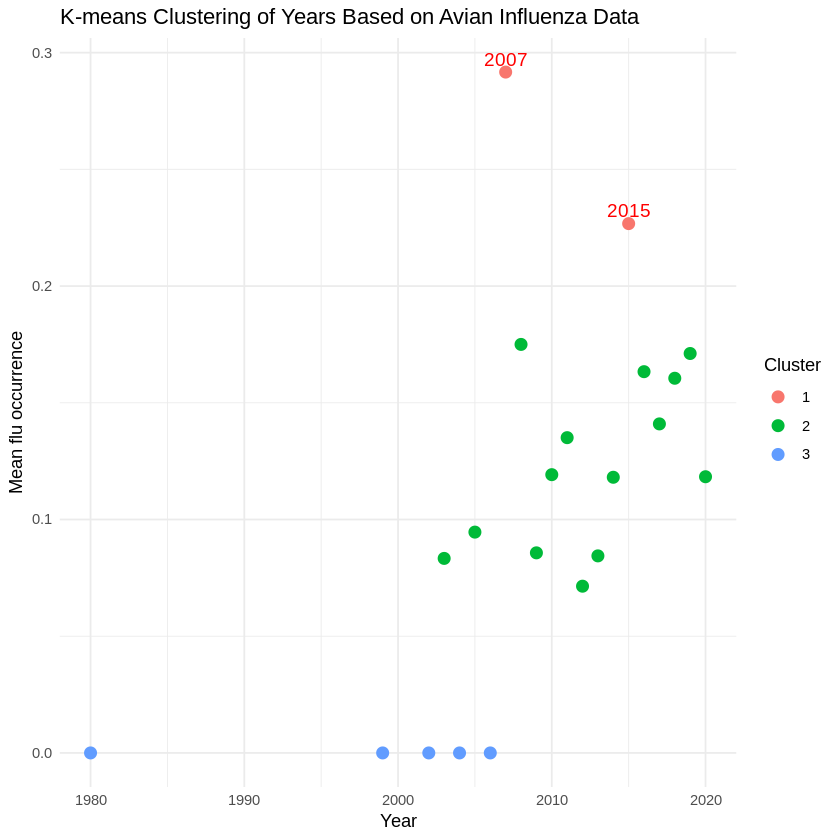

In [12]:
# Clustering analysis
# Aggregate data by Year
data <- data %>%
  mutate(target_H5_HPAI = as.numeric(as.character(target_H5_HPAI)))

yearly_summary <- data %>%
  group_by(Year) %>%
  summarize(
    h5_hpai_mean = mean(target_H5_HPAI, na.rm = TRUE) # Mean flu occurence per year
  )

# Standardize the features
features <- scale(yearly_summary[, c("h5_hpai_mean")])

# Determine optimal clusters using the Elbow Method
wss <- sapply(1:10, function(k) {
  kmeans(features, centers = k, nstart = 25)$tot.withinss
})

# Elbow Method Plot
elbow_plot <- data.frame(k = 1:10, wss = wss)
ggplot(elbow_plot, aes(x = k, y = wss)) +
  geom_point() +
  geom_line() +
  labs(title = "Elbow Method for Optimal k (Yearly Clustering)",
       x = "Number of Clusters (k)",
       y = "Total Within-Cluster Sum of Squares") +
  theme_minimal()
cat("\n")

# Apply K-means clustering with k=3
set.seed(128)
k <- 3
kmeans_model <- kmeans(features, centers = k, nstart = 50)

# Add cluster labels to the dataset
yearly_summary$Cluster <- as.factor(kmeans_model$cluster)

top_years <- yearly_summary %>%
  arrange(desc(h5_hpai_mean)) %>%
  slice(1:2)  # Top 2 years

# Scatter plot with year labels for top flu occurrence years
ggplot(yearly_summary, aes(x = Year, y = h5_hpai_mean, color = as.factor(Cluster))) +
  geom_point(size = 3) +
  geom_text(data = top_years, aes(x = Year, y = h5_hpai_mean, label = Year),
            vjust = -0.5, hjust = 0.5, size = 4, color = "red", inherit.aes = FALSE) +  # Fix legend issue
  labs(title = "K-means Clustering of Years Based on Avian Influenza Data",
       x = "Year", y = "Mean flu occurrence", color = "Cluster") +
  theme_minimal()

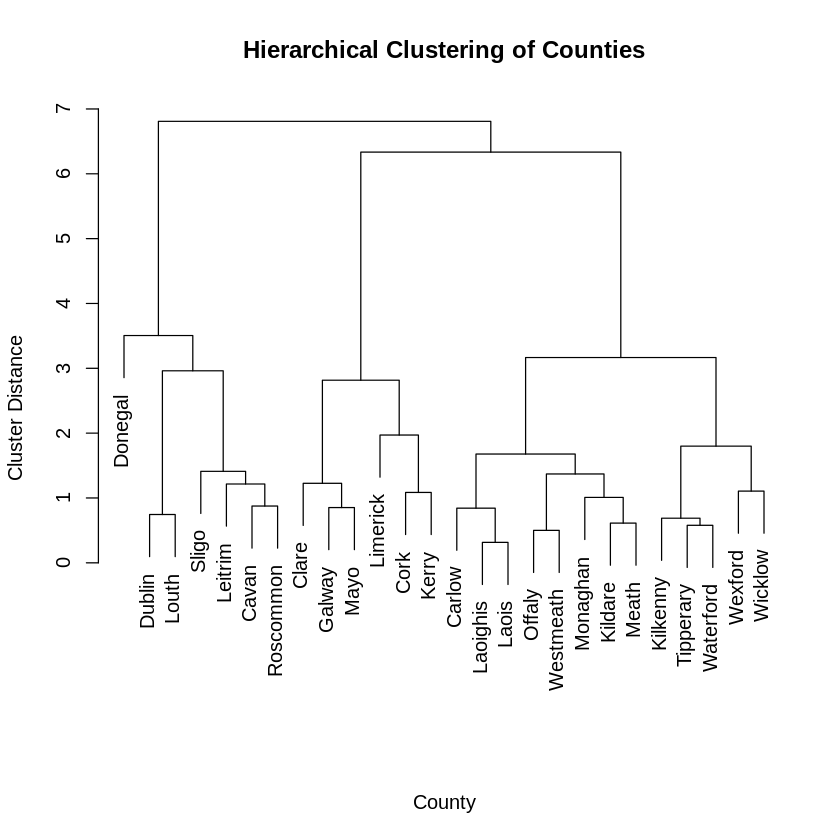

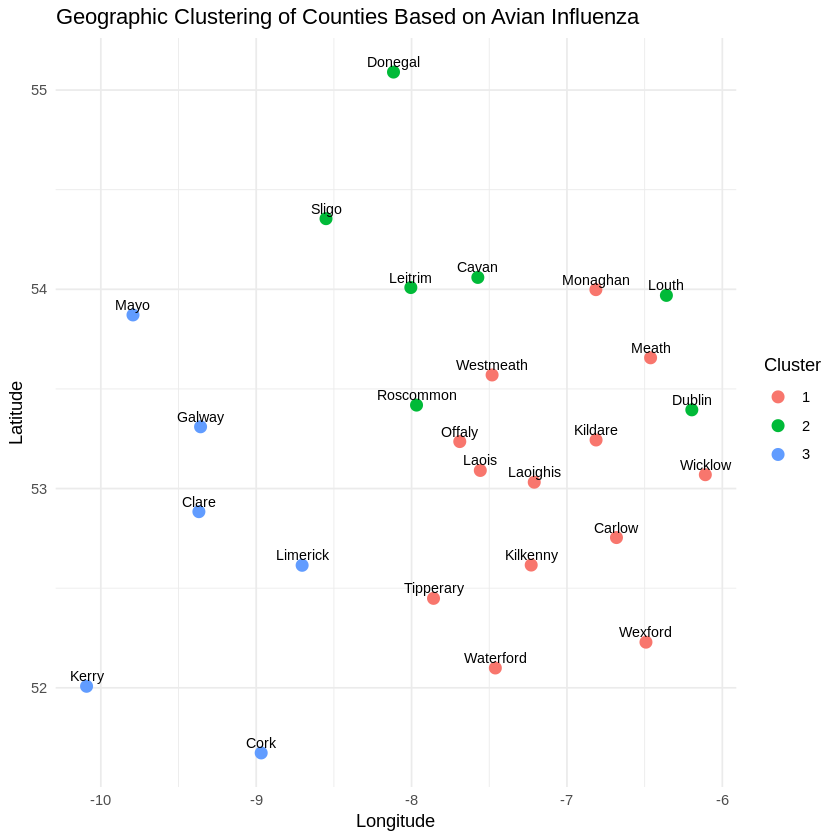

In [12]:
# Aggregate data by County for geographic clustering
geo_summary <- data %>%
  group_by(County) %>%
  summarize(
    count_cases = n(),
    h5_hpai_rate = 10*mean(target_H5_HPAI, na.rm = TRUE), # Mean flu occurence per county
    avg_latitude = mean(Latitude, na.rm = TRUE),
    avg_longitude = mean(Longitude, na.rm = TRUE)
  ) %>%
  drop_na()

# Standardize the features for clustering
geo_features <- scale(geo_summary[, c("h5_hpai_rate", "avg_latitude", "avg_longitude")])

# Compute hierarchical clustering using Ward's method
hclust_result <- hclust(dist(geo_features), method = "ward.D2")

# Plot the dendrogram
plot(hclust_result, labels = geo_summary$County, main = "Hierarchical Clustering of Counties",
     xlab = "County", ylab = "Cluster Distance", sub = "")

# Assign clusters
num_clusters <- 3  # Adjust as needed
geo_summary$Cluster <- as.factor(cutree(hclust_result, k = num_clusters))

# Visualizing clusters with County labels
ggplot(geo_summary, aes(x = avg_longitude, y = avg_latitude, color = Cluster)) +
  geom_point(size = 3) +
  geom_text(aes(x = avg_longitude, y = avg_latitude, label = County),
            vjust = -0.5, hjust = 0.5, size = 3, color = "black", inherit.aes = FALSE) +  # Fix legend issue
  labs(title = "Geographic Clustering of Counties Based on Avian Influenza",
       x = "Longitude", y = "Latitude", color = "Cluster") +
  theme_minimal()

In [13]:
yearly_summary

Year,avg_latitude,avg_longitude,h5_hpai_mean,Cluster
<int>,<dbl>,<dbl>,<dbl>,<fct>
1980,52.69630,-8.815300,0.00000000,3
1999,51.63050,-8.547000,0.00000000,3
2002,53.18360,-6.186300,0.00000000,3
2003,52.84914,-8.017067,0.08333333,2
2004,52.69942,-8.745204,0.00000000,3
2005,52.95788,-8.341885,0.09459459,2
2006,52.38449,-8.797175,0.00000000,3
2007,52.88931,-8.939592,0.29166667,1
2008,53.25602,-8.126100,0.17500000,2


In [14]:
geo_summary
nrow(geo_summary)

County,count_cases,h5_hpai_rate,avg_latitude,avg_longitude,Cluster
<fct>,<int>,<dbl>,<dbl>,<dbl>,<fct>
Carlow,13,0.0000000,52.75403,-6.681308,1
Cavan,10,3.0000000,54.05957,-7.573510,2
Clare,989,0.8392315,52.88396,-9.368799,3
Cork,1275,1.2392157,51.67311,-8.967829,3
Donegal,559,0.6082290,55.09022,-8.116310,2
Dublin,5191,2.2654594,53.39501,-6.196286,2
Galway,2502,1.5747402,53.31000,-9.358006,3
Kerry,1408,1.0937500,52.00758,-10.091727,3
Kildare,62,0.4838710,53.24368,-6.812603,1


[1] 26

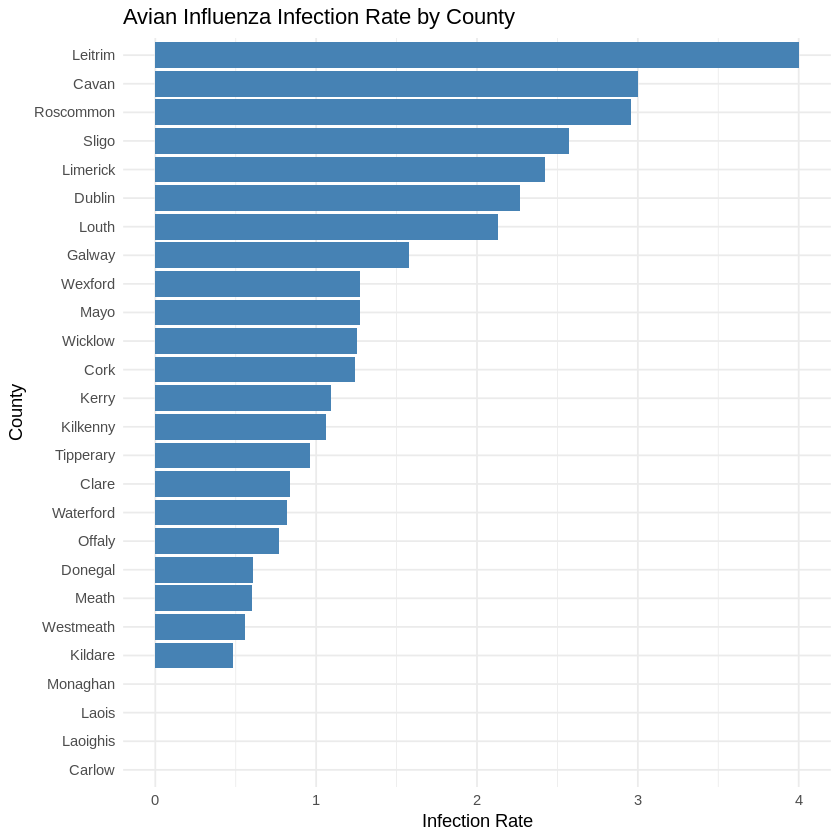

In [15]:
geo_summary <- geo_summary %>%
  mutate(County = fct_reorder(County, h5_hpai_rate))

ggplot(geo_summary, aes(x = County, y = h5_hpai_rate)) +
  geom_bar(stat = "identity", fill = "steelblue") +
  coord_flip() +  # Flip coordinates for better readability
  labs(title = "Avian Influenza Infection Rate by County",
       x = "County",
       y = "Infection Rate") +
  theme_minimal()